## Project 1 (Due 2/17)

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File. 

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Day 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('lmf_parsed.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)

## Part 1: Wrangling and EDA

In [3]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Download the demographic data for the 1999--2000 wave from the NHANES page. 

In [49]:
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

### The variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

`ELIGSTAT` : Eligibility Status for Mortality Follow-up. 
- Describes whether or not the individual (identified by their SEQN) is eligible for the mortality follow-up study.
- Values: 1 (Eligible), 2 (Under age 18, not available for public release), and 3 (Ineligible).
- Survey participants are defined as ineligible for mortality linkage if they had insufficient identifying data.

`MORTSTAT` : Final Mortality Status
- Describes the final determination of vital status and should be used as an outcome variable to calculate survival
- Values: 0 (Assumed alive), 1 (Assumed deceased), . (Ineligible or under 18)

`PERMTH_INT` : Number of Person Months of Follow-up from NHANES interview date 
- Describes the number of person-months from interview until death.
- Values: Int 0-374, . (Ineligible or under 18)
- Participants who are assumed alive are assigned the number of person months at the end of the mortality period

`RIDAGEEX` : Exam Age in Months
- Best age in months at date of examination for individuals under 85 years of age at screening.
- Values: Int 0-1019

###  Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

We chose the Immunization (IMQ)

In [50]:
imq = pd.read_sas("IMQ.xpt", format="xport") # Load early childhood questionairre
df2 = imq.merge(df, on="SEQN", how="inner") # Merge IMQ and demographics/mortality on SEQN variable
df2.head()

,SEQN,IMQ010,IMQ020,IMQ030,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,...,WTIREP50,WTIREP51,WTIREP52,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,PERMTH_INT,PERMTH_EXM
0,1.0,3.0,2.0,NaN,1.0,2.0,2.0,2.0,2.0,29.0,...,10327.992682,9809.165049,10323.315747,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,3.0,3.0,9.0,1.0,2.0,2.0,1.0,77.0,926.0,...,27268.025234,27406.383620,26984.812909,1,1.0,6.0,0.0,0.0,177.0,177.0
2,3.0,1.0,1.0,NaN,1.0,2.0,1.0,2.0,10.0,125.0,...,44480.987235,45389.112766,43781.905637,2,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,3.0,NaN,1.0,2.0,2.0,1.0,1.0,22.0,...,10851.024385,10564.981435,11012.529729,2,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,49.0,597.0,...,92817.926915,94282.855382,91993.251203,1,0.0,NaN,NaN,NaN,244.0,244.0


In [51]:
df2.isna().sum()

SEQN               0
IMQ010           740
IMQ020             5
IMQ030          5087
SDDSRVYR           0
                ... 
UCOD_LEADING    8291
DIABETES        8291
HYPERTEN        8291
PERMTH_INT      4520
PERMTH_EXM      4992
Length: 154, dtype: int64

In [39]:
imq.columns

Index(['SEQN', 'IMQ010', 'IMQ020', 'IMQ030'], dtype='object')

### Data Cleaning

In [ ]:
# filter dataframe down to only the relevant columns, those being the ones in the WHQ and those relating to mortality
imq_mort = df2[['SEQN', 'IMQ010', 'IMQ020', 'IMQ030',
       'ELIGSTAT', 'MORTSTAT', 'PERMTH_INT', 'RIDAGEEX']]

# ELIGSTAT of 1 means the participant was eligible for mortality data
# since that's what we want to observe, we should drop all rows where the person was ineligible
imq_mort = imq_mort[imq_mort['ELIGSTAT']==1]
imq_mort = imq_mort.drop(columns=['ELIGSTAT'])

# rename columns for clarity
imq_mort = imq_mort.rename(columns={"MORTSTAT": "mortality", "PERMTH_INT": "follow_up_time", "RIDAGEEX": "age_at_exam", "IMQ010": "hep_a", "IMQ020": "hep_b", "IMQ030": "pneumonia"}) 

# replace 7 and 9 with nan values
imq_mort[['hep_a','hep_b','pneumonia']] = imq_mort[['hep_a','hep_b','pneumonia']].replace([7, 9], [np.nan, np.nan])

# convert age values to years
imq_mort['age_at_exam'] = imq_mort['age_at_exam'] / 12

imq_mort.head()

,SEQN,hep_a,hep_b,pneumonia,mortality,follow_up_time,age_at_exam
1,2.0,3.0,3.0,NaN,1.0,177.0,77.166667
4,5.0,3.0,3.0,2.0,0.0,244.0,49.750000
5,6.0,3.0,3.0,NaN,0.0,246.0,19.166667
6,7.0,3.0,3.0,2.0,0.0,237.0,59.333333
9,10.0,NaN,NaN,NaN,1.0,231.0,43.166667


In [74]:
imq_mort_np = imq_mort.drop(columns=['pneumonia'])
imq_mort_np = imq_mort_np.dropna()
imq_mort_np.head()

,SEQN,hep_a,hep_b,mortality,follow_up_time,age_at_exam
1,2.0,3.0,3.0,1.0,177.0,77.166667
4,5.0,3.0,3.0,0.0,244.0,49.750000
5,6.0,3.0,3.0,0.0,246.0,19.166667
6,7.0,3.0,3.0,0.0,237.0,59.333333
11,12.0,3.0,1.0,0.0,236.0,37.833333


### Do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)

add more eda stuff here

### Day 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)
2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)
3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

### Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)

### Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)

### Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)

<Axes: xlabel='hep_a', ylabel='count'>

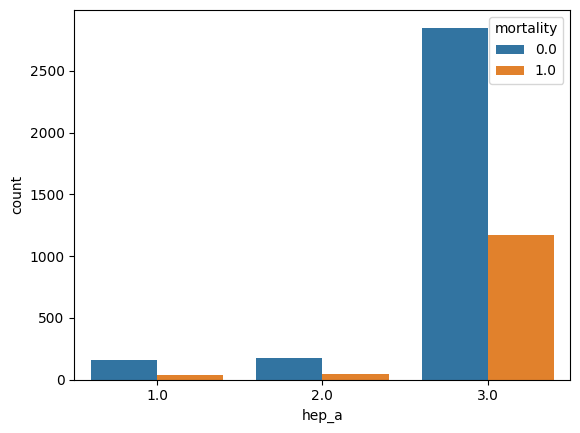

In [ ]:
sns.countplot(imq_mort_np, x='hep_a', hue='mortality')
sns.countplot(imq_mort_np, x='hep_b', hue='mortality')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

x = imq_mort_no_pnuemonia.loc[:,['hep_a', 'hep_b']]
y = imq_mort_no_pnuemonia['mortality']

model = KNeighborsClassifier(n_neighbors=1)
model = model.fit(x, y)
yHat = model.predict(x)

In [70]:
pd.crosstab(y, yHat)

col_0,0.0,1.0
mortality,,
0.0,794,2388
1.0,132,1123


In [71]:
model.score(x, y)

0.43204868154158216

### Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)

### Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)